# 1) Importing and checking Data:

In [0]:
#we will start by importing all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime as dt


sensor_col = ['sensor_measurement_1',
       'sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_5', 'sensor_measurement_6', 'sensor_measurement_7',
       'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_10', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13',
       'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_16', 'sensor_measurement_17', 'sensor_measurement_18', 'sensor_measurement_19',
       'sensor_measurement_20', 'sensor_measurement_21' ]

#Then we will be importing our necessary Data
#NB: I will only work on the FD001 DataSet
#train_data=pd.read_csv("../input/nasa-cmaps/CMaps/train_FD001.txt",sep='\s+',names=columns)
#test_data=pd.read_csv("../input/nasa-cmaps/CMaps/test_FD001.txt",sep='\s+',names=columns)
#true_rul=pd.read_csv("../input/nasa-cmaps/CMaps/RUL_FD001.txt",sep='\s+',names=['RUL'])

train_data_spark = spark.table("jet_engine_predictive_maintenance.dev.train_data")
train_data = train_data_spark.toPandas()
test_data_spark = spark.table("jet_engine_predictive_maintenance.dev.test_data")
test_data = test_data_spark.toPandas()
true_rul_spark = spark.table("jet_engine_predictive_maintenance.dev.rul_fd_001")
true_rul = true_rul_spark.toPandas() 

#And let's print it out and its shape to check it
print('train data and shape:')
print(train_data)
print(train_data.shape)
print('test data and shape: ')
print(test_data)
print(test_data.shape)

train data and shape:
       unit_number  ...  sensor_measurement_21
0                1  ...                23.4190
1                1  ...                23.4236
2                1  ...                23.3442
3                1  ...                23.3739
4                1  ...                23.4044
...            ...  ...                    ...
20626          100  ...                22.9735
20627          100  ...                23.1594
20628          100  ...                22.9333
20629          100  ...                23.0640
20630          100  ...                23.0522

[20631 rows x 26 columns]
(20631, 26)
test data and shape: 
       unit_number  ...  sensor_measurement_21
0                1  ...                23.3735
1                1  ...                23.3916
2                1  ...                23.4166
3                1  ...                23.3737
4                1  ...                23.4130
...            ...  ...                    ...
13091          100  ... 

# 2) EDA:

Our work starts with the EDA (exploratory Data Analysis) so first we will begin by analysing the train data.

**Data Description:**

In [0]:
#now we will creat a function to describe our data
def data_desc(data):
    print('Data description:')
    return data.describe().transpose()

print(data_desc(train_data))

Data description:
                         count         mean  ...        75%        max
unit_number            20631.0    51.506568  ...    77.0000   100.0000
time_in_cycles         20631.0   108.807862  ...   156.0000   362.0000
op_setting_1           20631.0    -0.000009  ...     0.0015     0.0087
op_setting_2           20631.0     0.000002  ...     0.0003     0.0006
op_setting_3           20631.0   100.000000  ...   100.0000   100.0000
sensor_measurement_1   20631.0   518.670000  ...   518.6700   518.6700
sensor_measurement_2   20631.0   642.680934  ...   643.0000   644.5300
sensor_measurement_3   20631.0  1590.523119  ...  1594.3800  1616.9100
sensor_measurement_4   20631.0  1408.933782  ...  1414.5550  1441.4900
sensor_measurement_5   20631.0    14.620000  ...    14.6200    14.6200
sensor_measurement_6   20631.0    21.609803  ...    21.6100    21.6100
sensor_measurement_7   20631.0   553.367711  ...   554.0100   556.0600
sensor_measurement_8   20631.0  2388.096652  ...  2388.1400

* Analysis:
    
We can see that our Data Set consists of 100 engines in total with a total of 20631 (count) observations divided on its last but with different numbers for each engine since each engine is tested until failure. Looking further into the data summary, we see that some columns have a standard deviation (std) equal to 0, which means that this value is constant across all the cycles of each engine, so it will not affect the degradation
* Conclusion:

    :
Some sensors and parameters are constant or quasi-constant, which means that they might not be very useful in a predictive model. So we can later remove parameter 3 "setting3" and sensors 1,10,18,19 "sensor1", "sensor10", "sensor18", "sensor19".
But a deeper analysis would be necessary to determine the most important sensors and parameters for modeling

**Checking for missing values:**

In [0]:
def check_missing_values(data):
    print('Verifing the existance of null data:')
    return data.isnull().sum()

print(check_missing_values(train_data))

Verifing the existance of null data:
unit_number              0
time_in_cycles           0
op_setting_1             0
op_setting_2             0
op_setting_3             0
sensor_measurement_1     0
sensor_measurement_2     0
sensor_measurement_3     0
sensor_measurement_4     0
sensor_measurement_5     0
sensor_measurement_6     0
sensor_measurement_7     0
sensor_measurement_8     0
sensor_measurement_9     0
sensor_measurement_10    0
sensor_measurement_11    0
sensor_measurement_12    0
sensor_measurement_13    0
sensor_measurement_14    0
sensor_measurement_15    0
sensor_measurement_16    0
sensor_measurement_17    0
sensor_measurement_18    0
sensor_measurement_19    0
sensor_measurement_20    0
sensor_measurement_21    0
dtype: int64


* Analysis:

    All data seems complete, without any missing values.
* Conclusion:

    All data has been ready to process so we can directly start our graphical and in-depth analysis.

**Finding max cycles of each engine:**

Since in our training database all engines are run to failure, this allows us to determine the maximum cycles of each engine.

In [0]:
def find_max_cycle(data):
    print('The max cycles of each engine: ')
    max_cycle = data[['unit_number', 'time_in_cycles']].groupby(['unit_number']).count().reset_index().rename(columns={'time_in_cycles': 'max_cycles'})
    return max_cycle

max_cycle=find_max_cycle(train_data)
print(max_cycle)

#i.e we can see that engine 1 failed after 192 cyclees and engin 2 failed after 287 cycles as it goes throw each engine
#these cyclce will serve us in while plotting the data since we are going to use this late in the data plotting as an x axis

The max cycles of each engine: 
    unit_number  max_cycles
0             1         192
1             2         287
2             3         179
3             4         189
4             5         269
..          ...         ...
95           96         336
96           97         202
97           98         156
98           99         185
99          100         200

[100 rows x 2 columns]


In [0]:
train_data.head(30) 

unit_number  time_in_cycles  ...  sensor_measurement_20  sensor_measurement_21
0             1               1  ...                  39.06                23.4190
1             1               2  ...                  39.00                23.4236
2             1               3  ...                  38.95                23.3442
3             1               4  ...                  38.88                23.3739
4             1               5  ...                  38.90                23.4044
5             1               6  ...                  38.98                23.3669
6             1               7  ...                  39.10                23.3774
7             1               8  ...                  38.97                23.3106
8             1               9  ...                  39.05                23.4066
9             1              10  ...                  38.95                23.4694
10            1              11  ...                  38.94                23.4787
11            1              12  ...                  39.06                23.3660
12            1              13  ...                  38.93                23.2757
13            1              14  ...                  39.18                23.3826
14            1              15  ...                  38.99                23.3500
15            1              16  ...                  38.97                23.4550
16            1              17  ...                  38.81                23.3319
17            1              18  ...                  38.89                23.3987
18            1              19  ...                  38.80                23.3464
19            1              20  ...                  39.03                23.4220
20            1              21  ...                  39.09                23.3101
21            1              22  ...                  38.92                23.3792
22            1              23  ...                  38.94                23.4562
23            1              24  ...                  39.00                23.3696
24            1              25  ...                  38.95                23.4288
25            1              26  ...                  38.86                23.4149
26            1              27  ...                  38.99                23.4472
27            1              28  ...                  39.01                23.2841
28            1              29  ...                  38.93                23.3597
29            1              30  ...                  39.05                23.4110

[30 rows x 26 columns]

So now we will describe this data graphically for better reading.

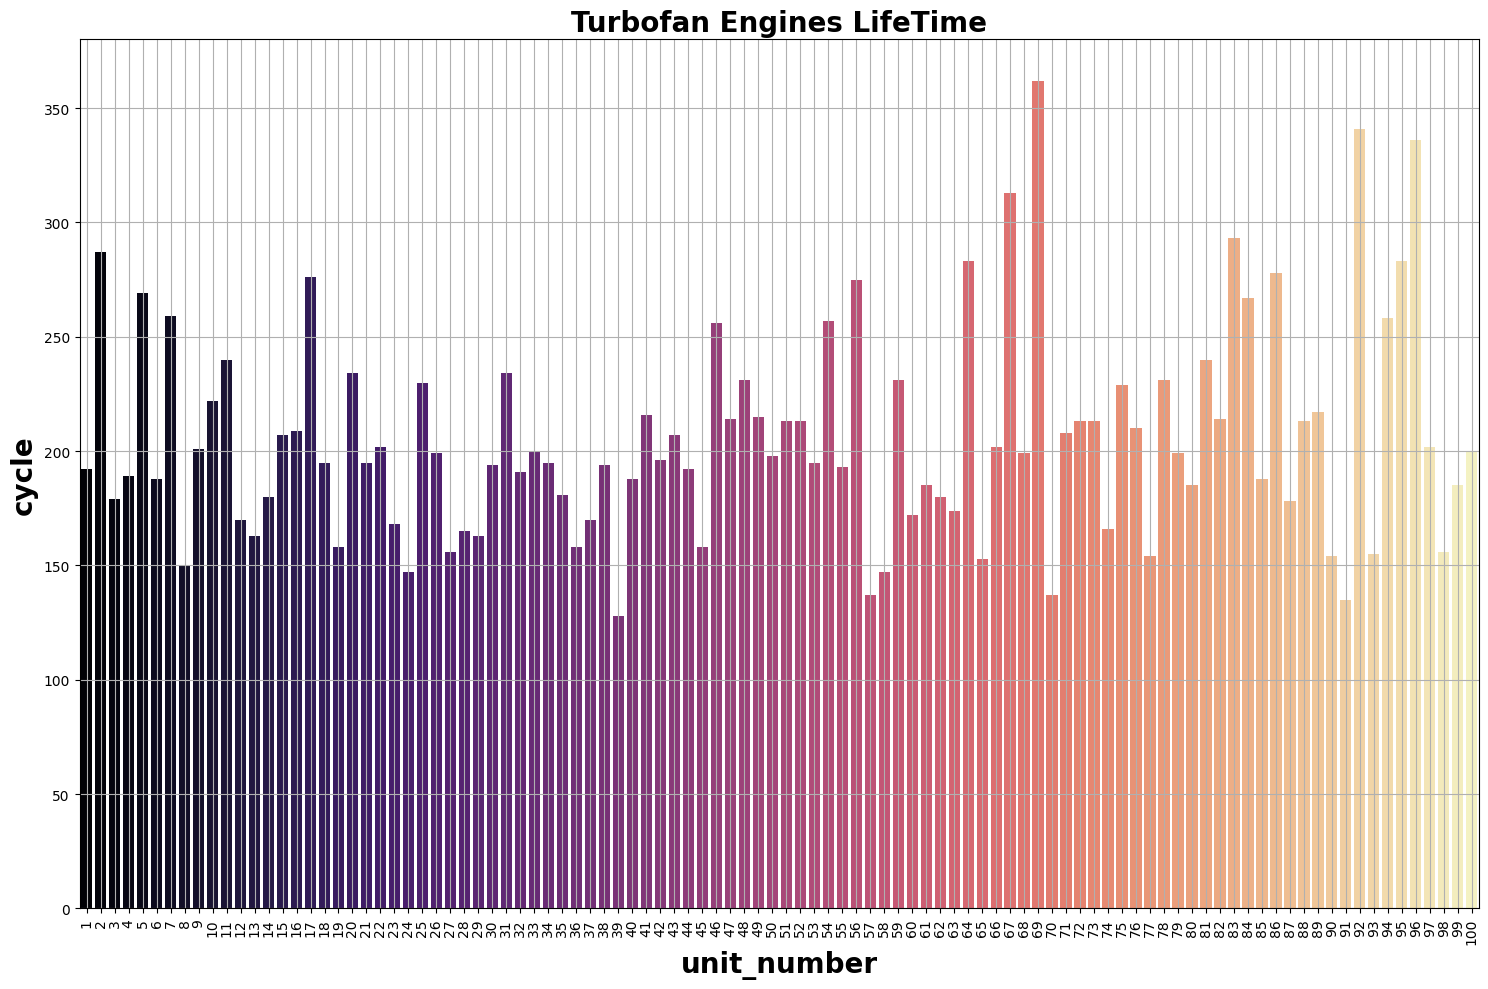

In [0]:
#So acutally let's plot this for better understanding
def barplt(data):
       plt.figure(figsize=(15,10))
       sns.barplot(x='unit_number', y='max_cycles', data=data,palette='magma')
       sns.set_context(font_scale=0.01)
       plt.title('Turbofan Engines LifeTime',fontweight='bold',size=20)
       plt.xlabel('unit_number',fontweight='bold',size=20)
       plt.ylabel('cycle',fontweight='bold',size=20)
       plt.xticks(rotation=90)
       plt.grid(True)
       plt.tight_layout()
barplt(max_cycle)

From this graph we can see that engine number 69 has performed the most cycles with a value of 362, which has already been confirmed by the summary of the data presented previously.
Also we can see that there is a value domain where all the engines fail.

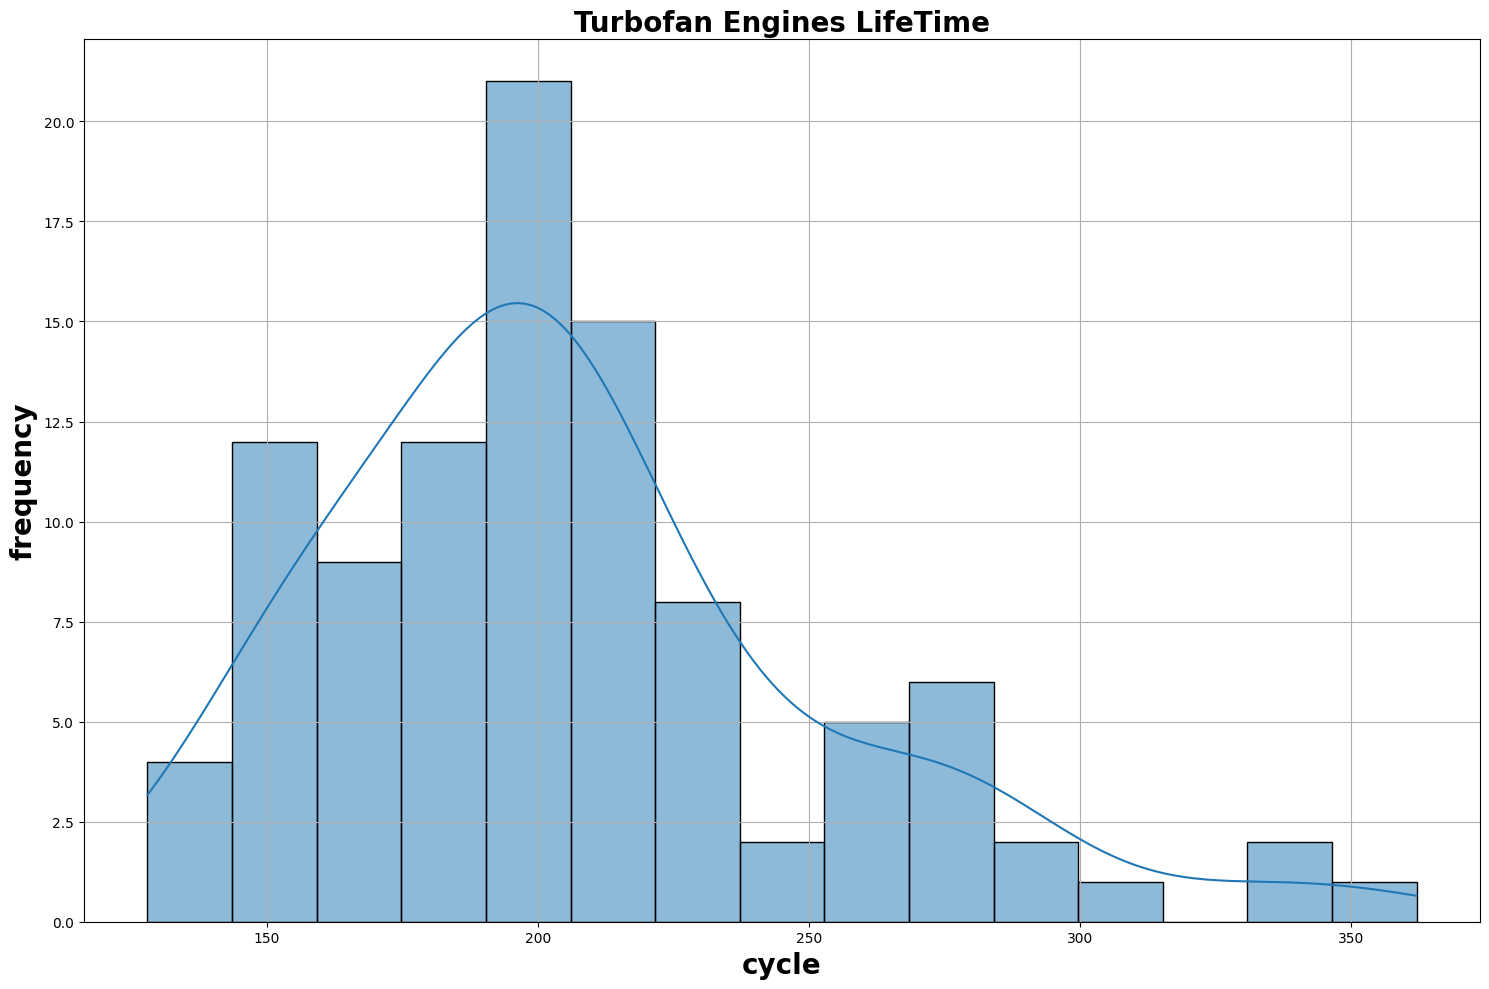

In [0]:
#then what about the distrubtion?
def distribution(data):
       plt.figure(figsize=(15, 10))
       sns.histplot(data=data['max_cycles'],kde='True',bins=15)
       sns.set_context(font_scale=0.01)
       plt.title('Turbofan Engines LifeTime',fontweight='bold',size=20)
       plt.xlabel('cycle',fontweight='bold',size=20)
       plt.ylabel('frequency',fontweight='bold',size=20)
       plt.grid(True)
       plt.tight_layout()
distribution(max_cycle)

The majority of motors appear to have a maximum life between 150 and 200 cycles, with a peak around 200 cycles, where the frequency reaches around 20 engines.
The distribution is slightly skewed, with a steeper downward slope after 200 cycles. This indicates that relatively fewenginess achieve high maximum lives, especially beyond 300 cycles.

**Remaining uselful life:**

Our previous analysis made us think about adding a new column to our Data Set which is the remaining life of each engine after each observation which is translated to a life cycle.

In [0]:
def add_remaining_RUL(data):
    train_data_by_engine = data.groupby(by='unit_number')
    max_cycles = train_data_by_engine['time_in_cycles'].max()
    merged = data.merge(max_cycles.to_frame(name='max_cycles'), left_on='unit_number',right_index=True)
    merged["RUL"] = merged["max_cycles"] - merged['time_in_cycles']
    merged = merged.drop("max_cycles", axis=1)
    return merged
train_data=add_remaining_RUL(train_data)
print(train_data)

       unit_number  time_in_cycles  ...  sensor_measurement_21  RUL
0                1               1  ...                23.4190  191
1                1               2  ...                23.4236  190
2                1               3  ...                23.3442  189
3                1               4  ...                23.3739  188
4                1               5  ...                23.4044  187
...            ...             ...  ...                    ...  ...
20626          100             196  ...                22.9735    4
20627          100             197  ...                23.1594    3
20628          100             198  ...                22.9333    2
20629          100             199  ...                23.0640    1
20630          100             200  ...                23.0522    0

[20631 rows x 27 columns]


With the help of this column we will finally be able to make more in-depth graphical analyses on the behavior of the sensors.

**Plotting info per engine:**

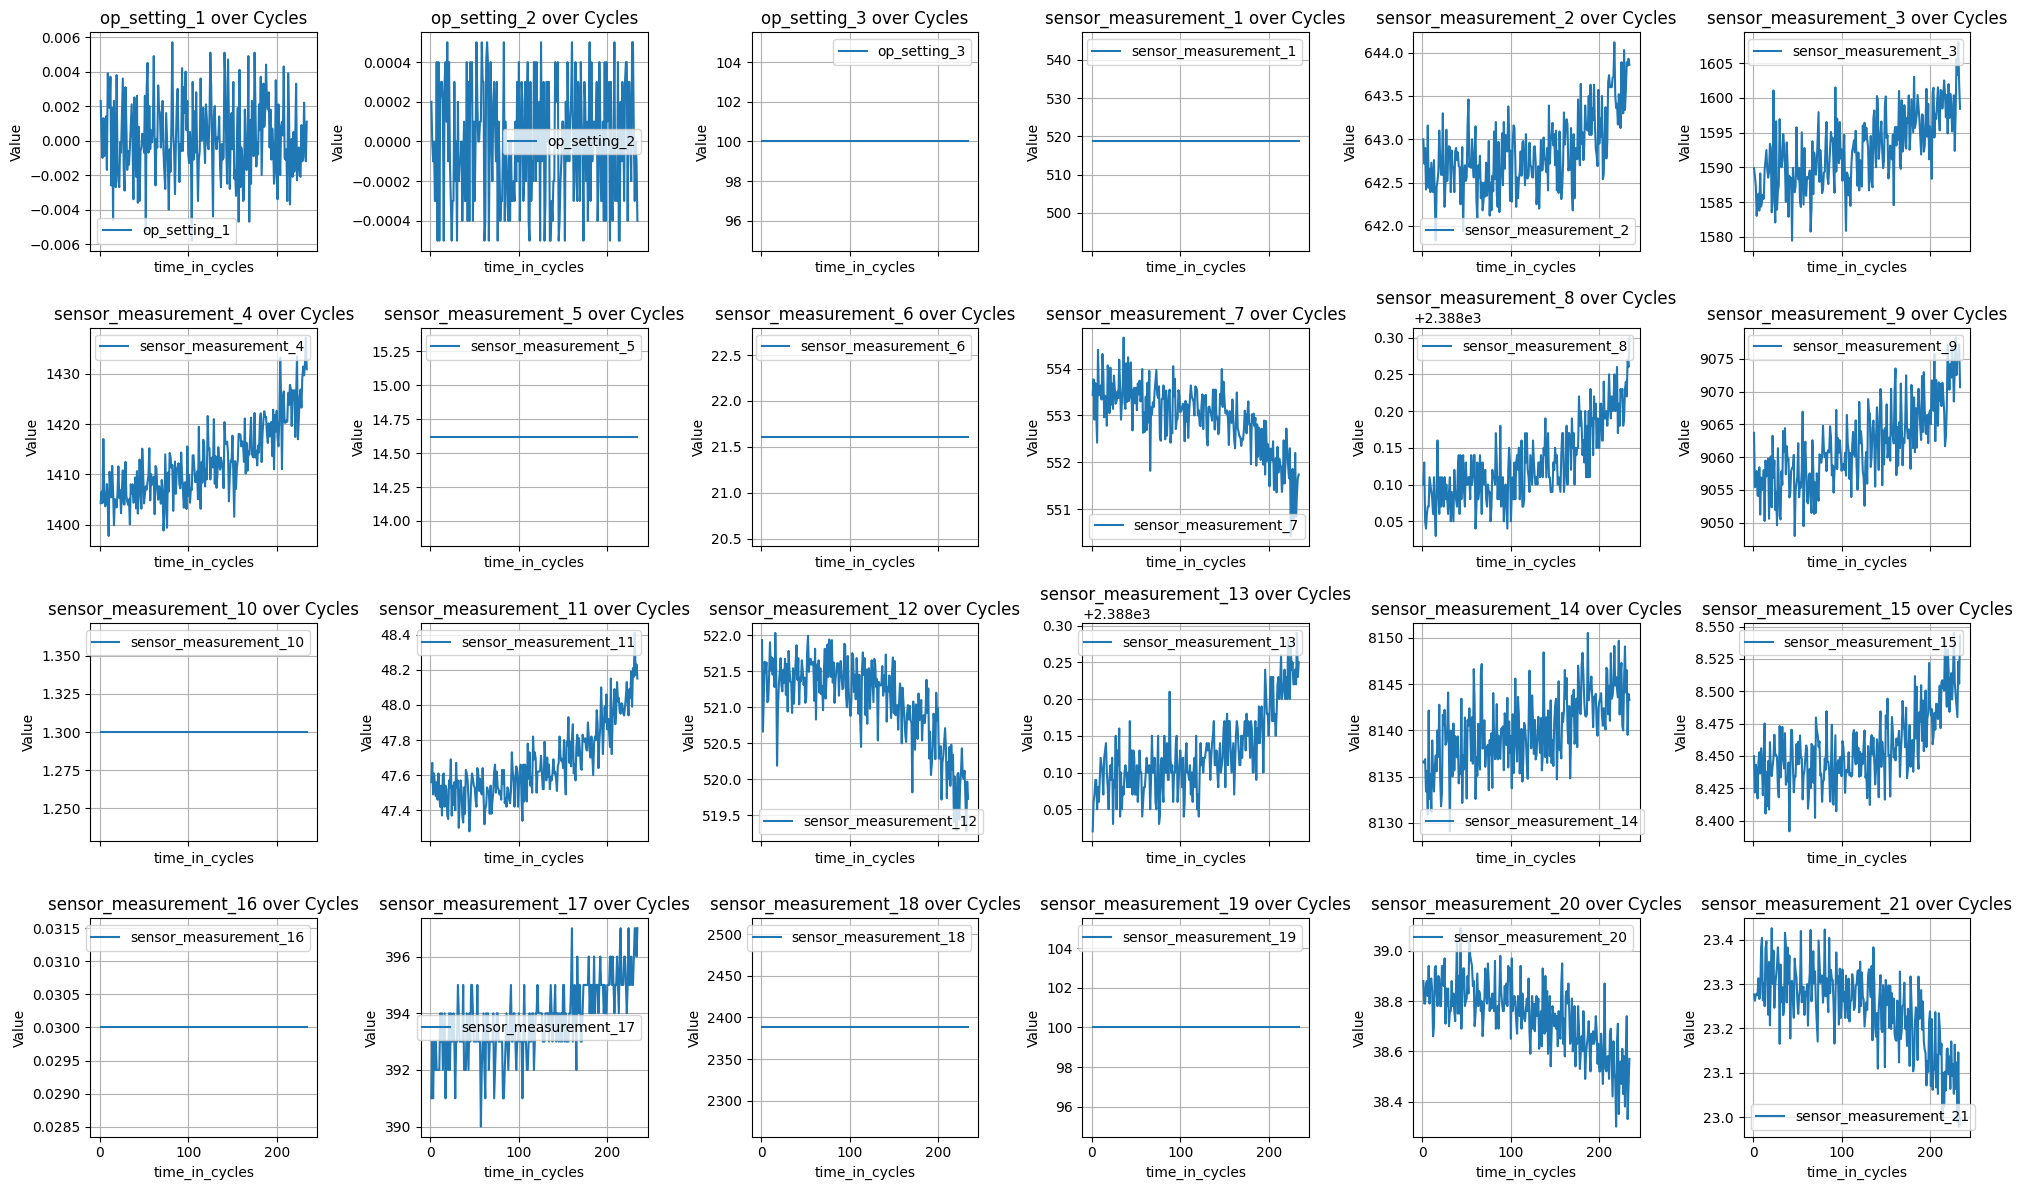

In [0]:
#and for more specific anaylsis this a function that shows plots the behavior of the sensors for a specific given engine number
#and this, along its remaining RUL
def info_plotting_per_engine(eng_num,data):
    engine_data = data[data['unit_number'] == eng_num]

    columns_to_plot = ['op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_measurement_{i}' for i in range(1, 22)] 

    num_columns = 6
    num_rows = (len(columns_to_plot) + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 3), sharex=True)

    for ax, column in zip(axes.flatten(), columns_to_plot):
        ax.plot(engine_data['time_in_cycles'], engine_data[column], label=column)
        ax.set_title(f'{column} over Cycles')
        ax.set_xlabel('time_in_cycles')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()
#just select the desired engine number
info_plotting_per_engine(20,train_data)

* **Analysis:**
As an example, we chose engine number 20 to plot its curves which presents the behavior of each sensor and even the 3 parameters used in each cycle.
We note that several sensors "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19" and parameter 3 "setting3" represent a continuous linear curve which explains that we have a constant value throughout the life cycle of this engine and moreover it was confirmed earlier in the general description of the Data Set knowing that any constant value will be useless for our predictive models.
We also observe that there is a perceptible change in the appearance of the remaining sensors even if the value of parameters 1 and 2 are different each time during the maximum life cycle of this engine. This is always represented by growth or decreas
* **conclusion:**
All the sensors mentioned "sensor5", "sensor6", "sensor16", we can remove them but first we must check if this value is true for all the engines even if we have already seen that it is true for some which are "sensor1", "sensor10", "sensor18", "sensor19" with parameter 3 "setting3".
Also we must check this behavior of the remaining sensors also for all the engines which can help us understand the reasons for engine degradations.
So we only have to confirm our hypothesis that all the sensors "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19" are all useless.

**Correlation matrix:**

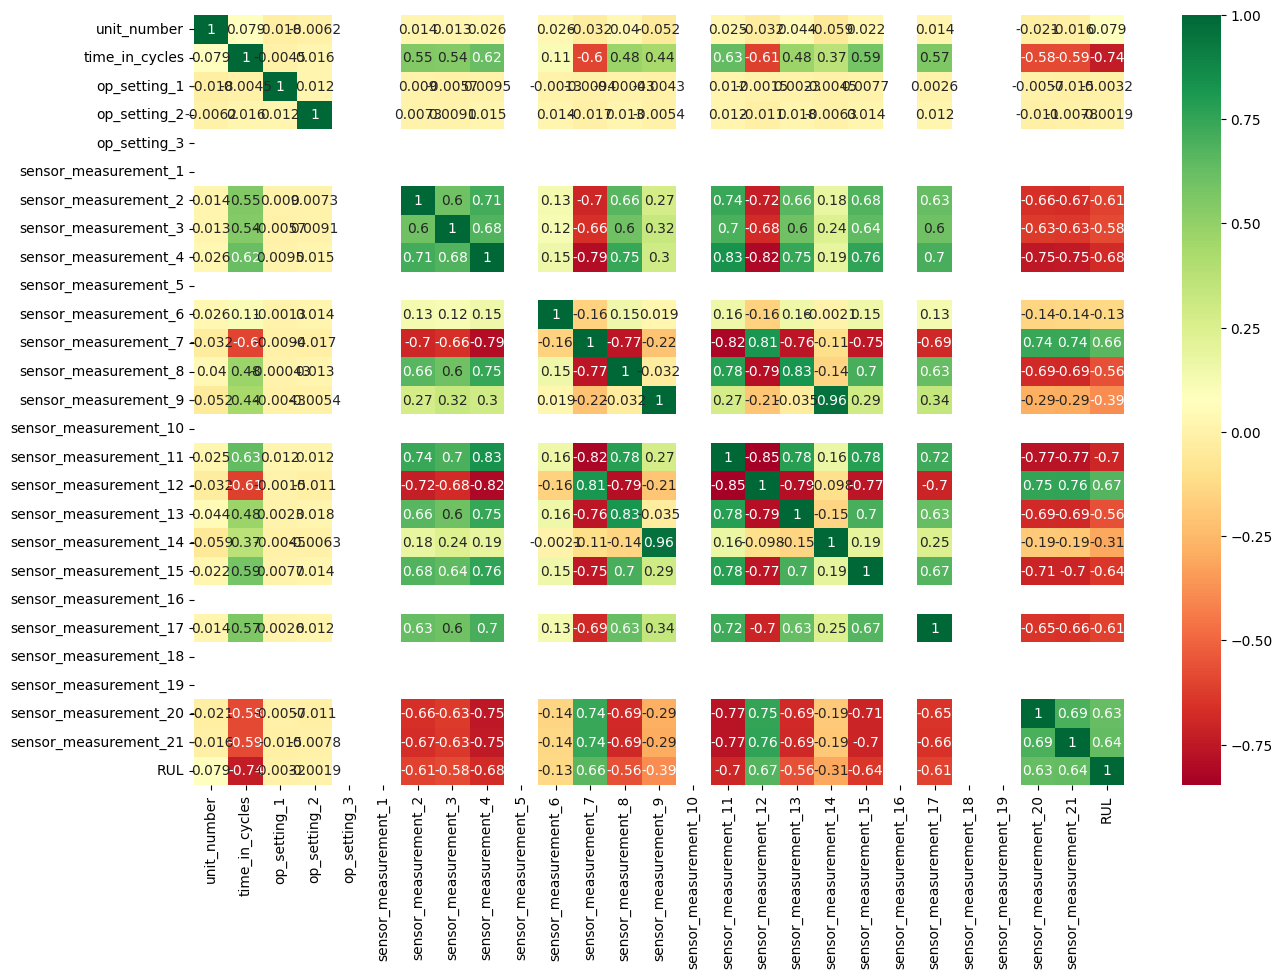

In [0]:
#now let's really see the correlation between data
def corr_matrix(data):
    plt.figure(figsize=(15, 10))
    sns.set_context(font_scale=0.01)
    sns.heatmap(data.corr(), annot=True, cmap='RdYlGn')
    plt.grid(False)


corr_matrix(train_data)

* **Analysis:**
We notice that there is a lack of correlation coefficient value for sensors 1,10,18,19 "sensor1", "sensor10", "sensor18", "sensor19" and parameter 3 "setting3" which we already talked about at the very beginning of our EDA this is explained by the fact that their standard deviation which is equal to 0 and the standard deviation is the square root of the variance.
For sensor 16 "sensor16" since its standard deviation "std" is very very close to 0 check in the data description at an exact value of 1.5564321e-14 so we could not calculate its correlation. Likewise for sensor 5 "sensor5" which admits a standard deviation "std" of 3.394700e-12.
Now we must focus on the correlation coefficient between the remaining life cycle "RUL" so we only check the last line. According to our matrix, we see that parameters 1 and 2 "setrting1", "setting2" have a coefficient very very close to 0. Similarly for sensor 6 "sensor6" it admits a negative coefficient too small with a value of -0.13.
Sensors 7,12,20 and 21 "sensor7", "sensor12", "sensor20", "sensor21" admit a strong positive correlation with "RUL" with consecutive values ​​of 0.66, 0.67, 0.63 and 0.64.
While the rest of the sensors have a negative correlation with "RUL" in particular 2,4,11,15,17 "sensor2", "sensor4", "sensor11", "sensor15", "sensor17" which have a strong negative correlation.
* **Conclusion:**
Since this analysis we have been able to confirm that all the following sensors will be useless in our predictive models that we will develop and its sensors are "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19". From where we will have the opportunity to remove them from our Data Set with also the 3 operating parameters.
For the remaining sensors the strong correlation whatever negative or positive explains to us that they have a strong critical relationship to the degradation of the engines so it will be necessary to have an even deeper analysis on each of its sensors to understand their usefulness and the reason for this degradation.orte


**Filtering data:**

This step is a step that is usually crucial in the data preprocessing phase but it can also be found in the “EDA” phase because as we have seen, with the data analysis we have found useless data that does not add any advantage to our prediction models. And at the same time we will apply this step on the test data too.

In [0]:
clean_train_data=train_data.drop(['op_setting_1','op_setting_2','sensor_measurement_6','sensor_measurement_5','sensor_measurement_16','op_setting_3','sensor_measurement_1','sensor_measurement_10','sensor_measurement_18','sensor_measurement_19'],axis=1)
clean_test_data=test_data.drop(['op_setting_1','op_setting_2','sensor_measurement_6','sensor_measurement_5','sensor_measurement_16','op_setting_3','sensor_measurement_1','sensor_measurement_10','sensor_measurement_18','sensor_measurement_19'],axis=1)
print('Data after our cleaning: ')
print(clean_train_data)

Data after our cleaning: 
       unit_number  time_in_cycles  ...  sensor_measurement_21  RUL
0                1               1  ...                23.4190  191
1                1               2  ...                23.4236  190
2                1               3  ...                23.3442  189
3                1               4  ...                23.3739  188
4                1               5  ...                23.4044  187
...            ...             ...  ...                    ...  ...
20626          100             196  ...                22.9735    4
20627          100             197  ...                23.1594    3
20628          100             198  ...                22.9333    2
20629          100             199  ...                23.0640    1
20630          100             200  ...                23.0522    0

[20631 rows x 17 columns]


**Deeper analysis of sensors:**

N.B.: Given the large number of engines which is 100, we will only represent a curve for every 5 engines, therefore 100/5 = 20, from which we only observe 20 engines or else we will not be able to read anything from the graphic representation

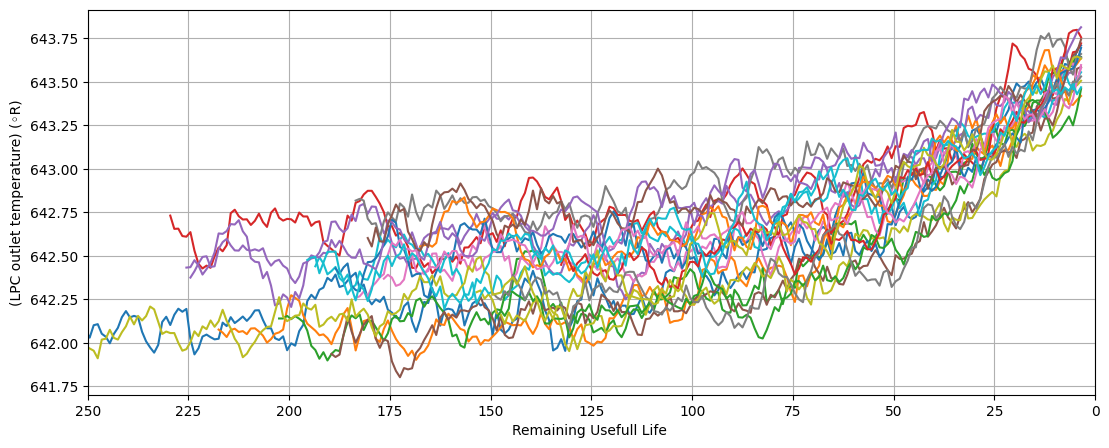

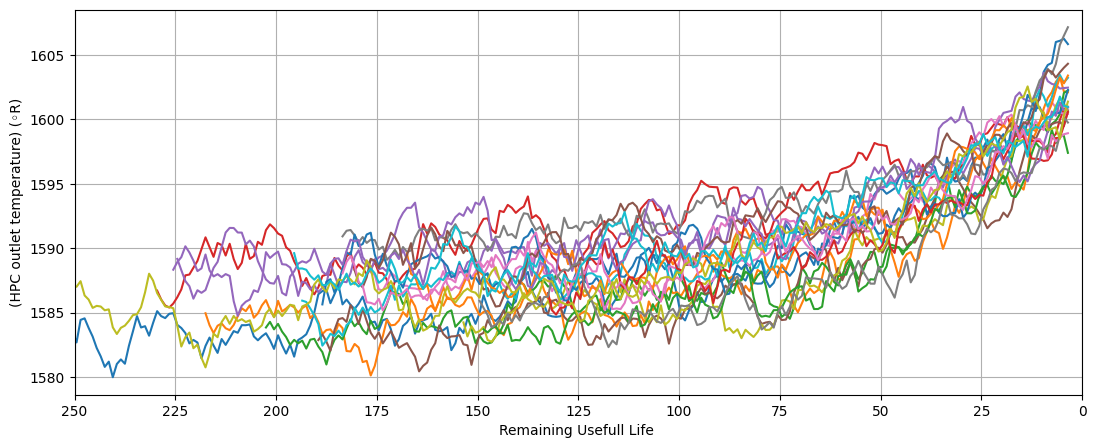

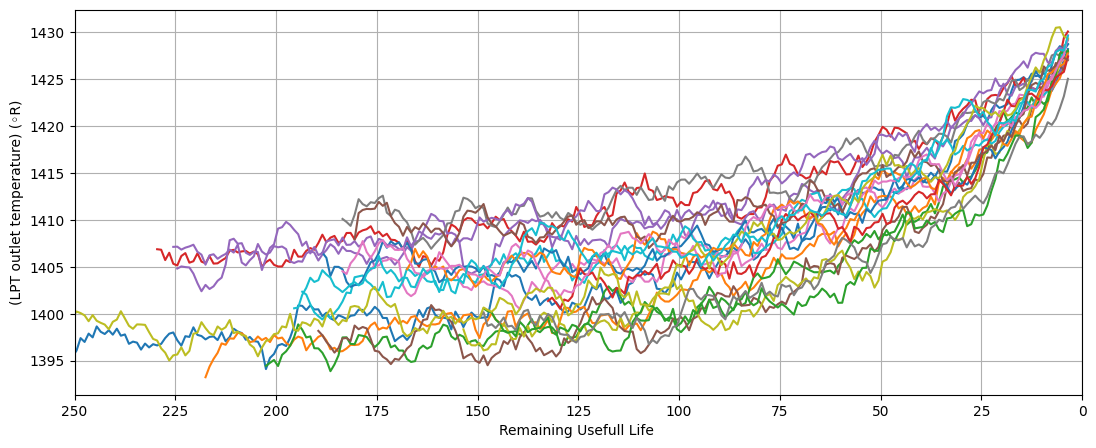

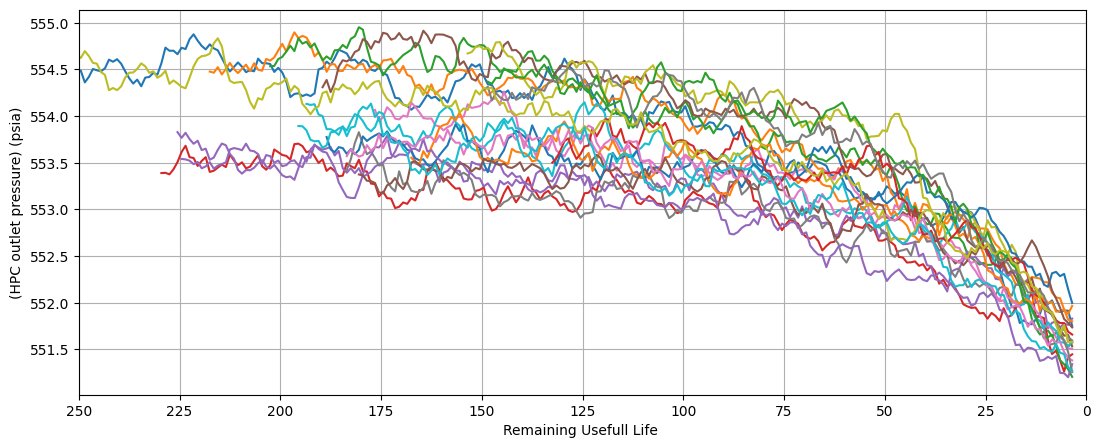

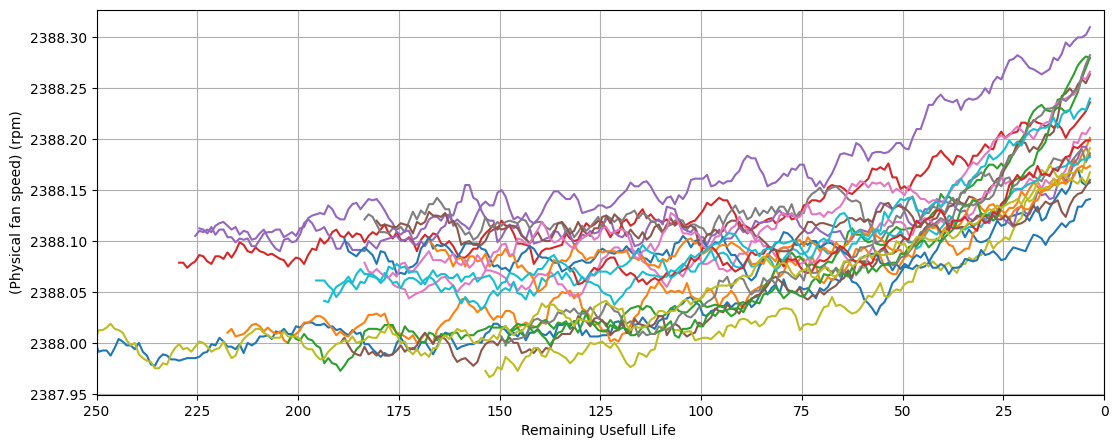

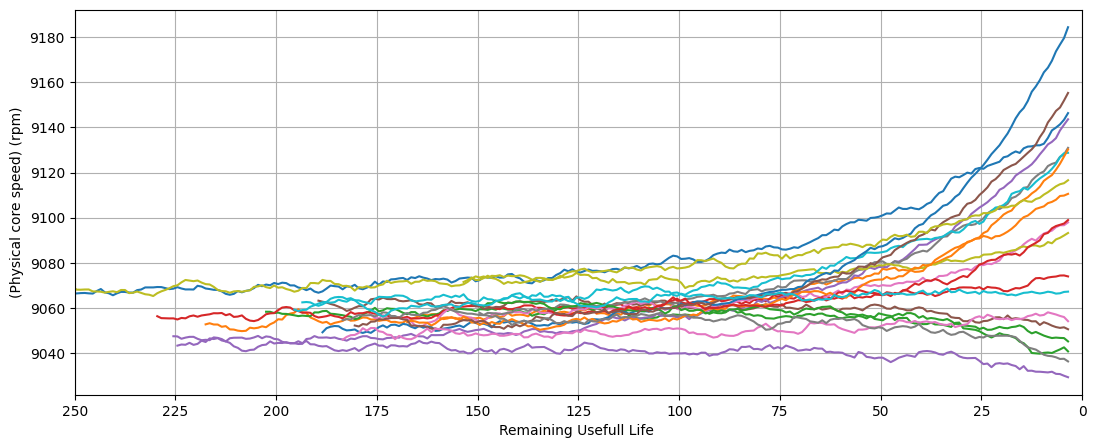

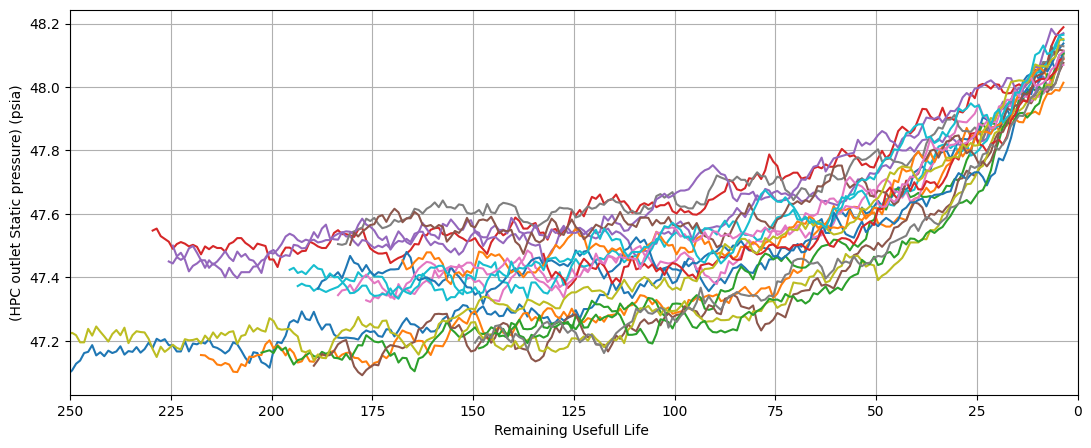

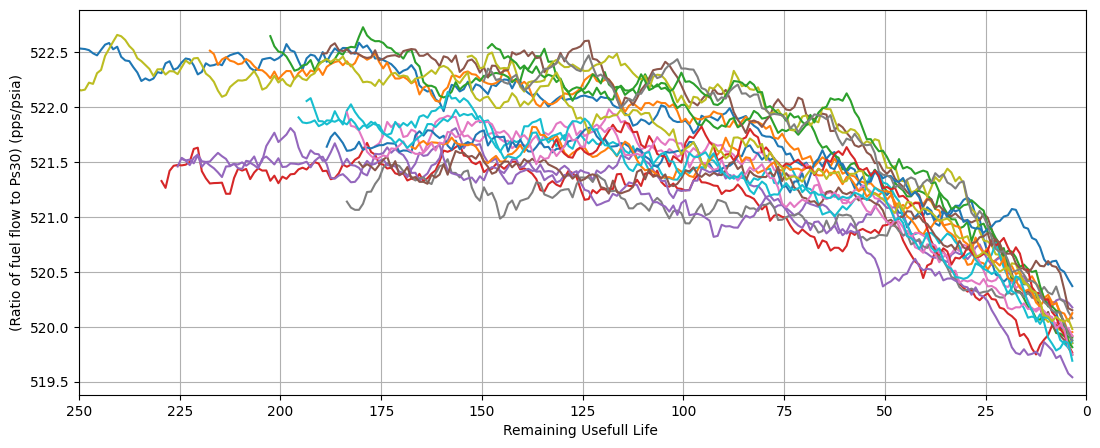

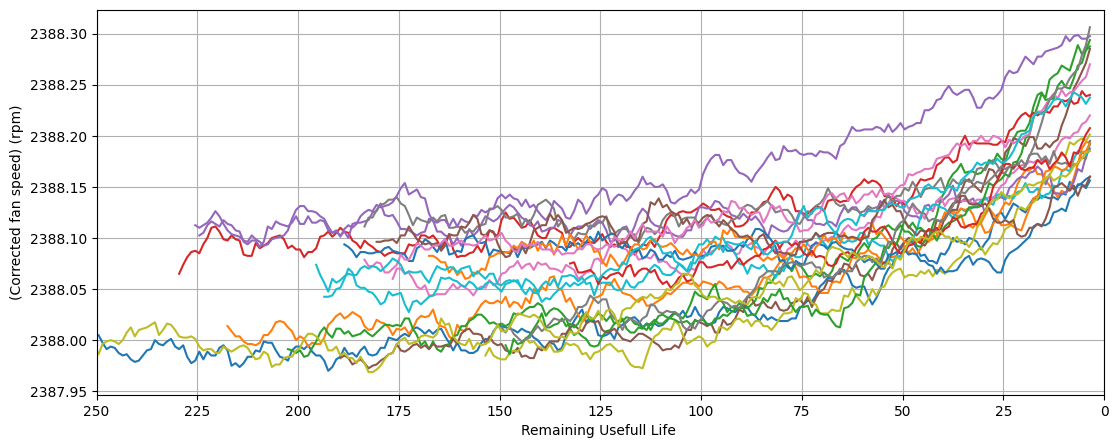

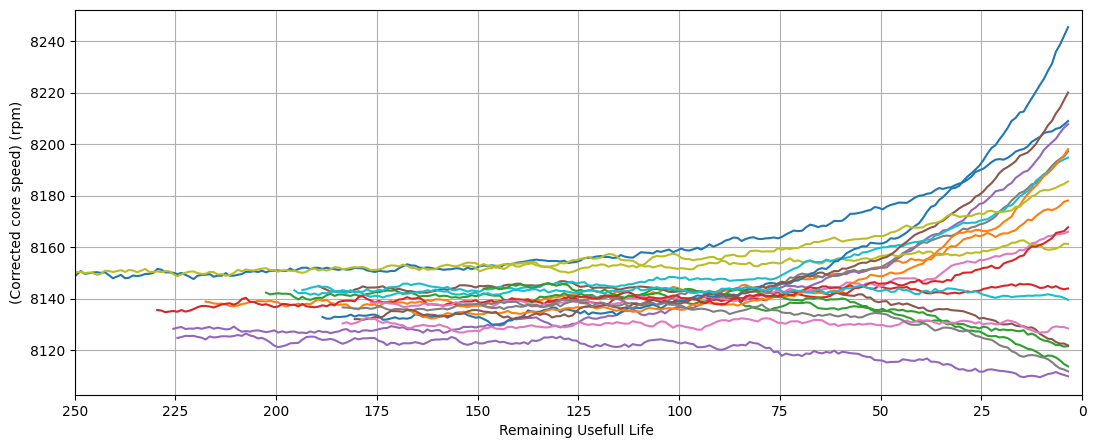

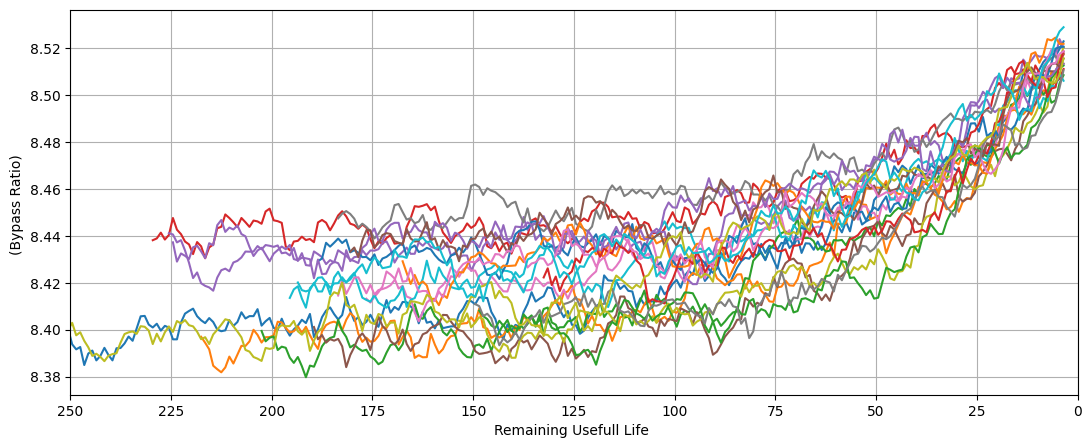

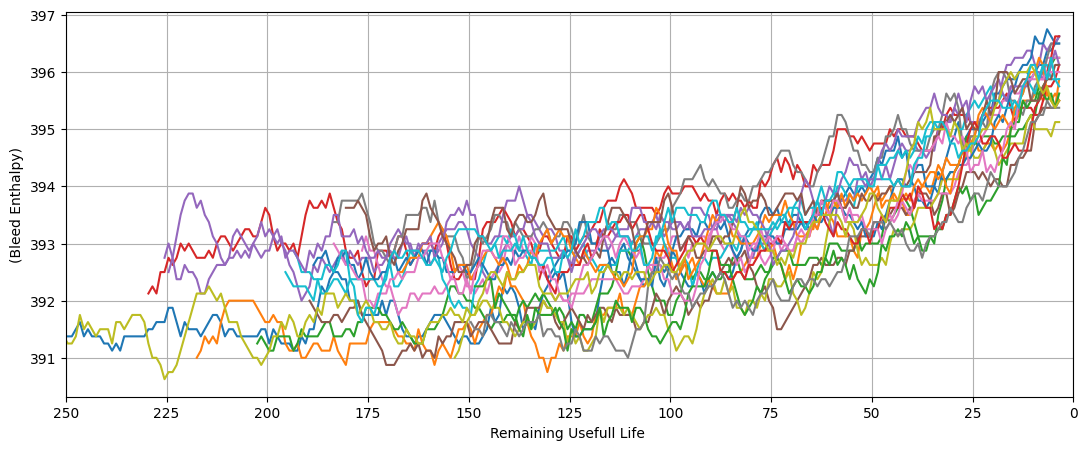

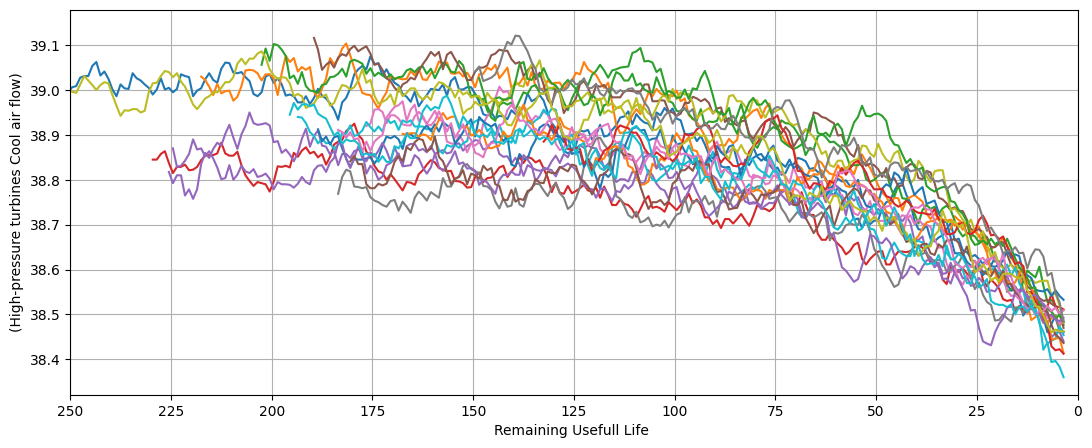

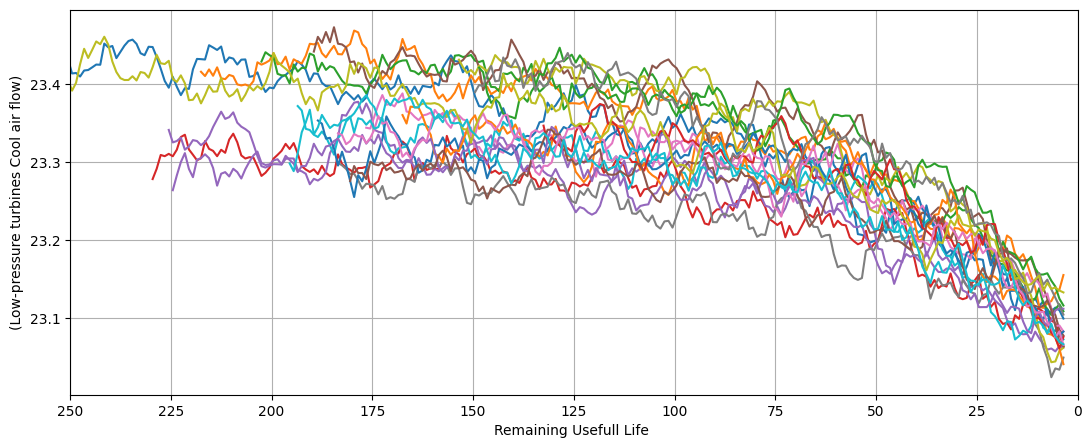

In [0]:
sens_names={
 'sensor_measurement_2': '(LPC outlet temperature) (◦R)',
 'sensor_measurement_3': '(HPC outlet temperature) (◦R)',
 'sensor_measurement_4': '(LPT outlet temperature) (◦R)',
 'sensor_measurement_7': '(HPC outlet pressure) (psia)',
 'sensor_measurement_8': '(Physical fan speed) (rpm)',
 'sensor_measurement_9': '(Physical core speed) (rpm)',
 'sensor_measurement_11': '(HPC outlet Static pressure) (psia)',
 'sensor_measurement_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 'sensor_measurement_13': '(Corrected fan speed) (rpm)',
 'sensor_measurement_14': '(Corrected core speed) (rpm)',
 'sensor_measurement_15': '(Bypass Ratio) ',
 'sensor_measurement_17': '(Bleed Enthalpy)',
 'sensor_measurement_20': '(High-pressure turbines Cool air flow)',
 'sensor_measurement_21': '(Low-pressure turbines Cool air flow)'}

def plot_sensor(sensor_name,sens_names,data):
    for S in sensor_name:

        if S in data.columns:
            plt.figure(figsize=(13, 5))
            for i in data['unit_number'].unique():

                if (i % 5 == 0):

                    plt.plot('RUL', S,
                             data=data[data['unit_number']==i].rolling(8).mean())


            plt.xlim(250, 0)
            plt.xticks(np.arange(0, 275, 25))
            plt.ylabel(sens_names[S])
            plt.xlabel('Remaining Usefull Life ')
            plt.grid(True)
            plt.show()
plot_sensor(sensor_col,sens_names,clean_train_data)

* **Sensor 2 analysis:** At the beginning, when the RUL is high (around 250), the temperature is relatively stable, with small fluctuations around 642 °R. 
As the RUL decreases (approaching 0), the LPC outlet temperature tends to increase. A more volatile behavior and growth are observed towards the end of the motors life even if there are fluctuations present throughout the curve
* **Sensor 3 analysis:** At the beginning of the RUL (around 250 cycles remaining), the HPC outlet temperature is relatively stable, oscillating around 1585 °R to 1590 °R.
As the RUL decreases (towards 0) and more precisely from around 125 cycles remaining, the HPC temperature starts to increase, until they reach values ​​above 1600 °R
* **Sensor 4 analysis:** At the beginning of the RUL (around 250 cycles remaining), the LPT outlet temperature is relatively stable, hovering around 1395°R to 1410°R. 
As the RUL decreases and the engine loses more of its cycles, and more precisely from around 75 cycles remaining, the LPT temperature starts to increase, until it reaches very high values.* **Sensor 7 analysis:** It is noted that at the beginning of the RUL, the HPC outlet pressure oscillates between 555 PSIA to 553 PISA which is stable and normal.
Arriving at 125 RUL remaining we notice that this HPC pressure begins to decrease more and more quickly in parallel with the decrease of the RUL of the motor
* **Sensor 8 analysis:** The fan speed remains stable at the beginning of the RUL, between 250 and 100 RUL. 
The more the RUL decreases, the more the speed increase becomes noticeable
* **Sensor 9 analysis:** Here we see that the curves are different for each engine. At the beginning the speed of the physical core remains constant between 9040 rpm and 9080 rpm until reaching 100 RUL remaining. There we observe a very remarkable change more and more when the RUL decreases further.
* **Sensor 11 analysis:** This sensor also shows us that the statistical pressure of the HPC outlet remains stable and constant at the beginning of the RUL with small oscillations around 47 pisa to 47.6 pisa. 
As the RUL decreases (approaching 0), the static pressure of the HPC outlet tends to increase. We observe an increase towards the end of the life of the motors even if there are fluctuations present throughout the curve
* **Sensor 12 analysis:** Similarly for the fuel flow ratio it remains stable and starts to decrease hence the engine uses less and less fuel as it deteriorates. This is observed towards the end of the RUL when there are only 100 to 75 RUL left and this flow rate decreases rapidly to a value below 520 pps/psia.
* **Sensor 13 & 14 analysis:** Looking at these two sensors we see that they look very similar to sensors 8 and 9. All 4 explain the fan speed behavior.
* **Sensor 15 analysis:** Analyzing this curve we see a behavior that admits a form somewhat similar to the other sensors with a normal and stable fluctuation at the beginning of the life cycle of the engines and after 100 to 75 of remaining life there is a change in the shape of the curves with an increase in the value of the derivation.
* **Sensor 17 analysis:** From reading this graph we see that the value of the purge enthalpy, at the beginning of the engine life cycle, it takes a stable value of interval 391 and 394.
After the RUL reaches 75 remaining life cycles, the curve takes an increase in its appearance until it reaches a maximum value greater than 396
* **Sensor 20 & 21 analysis:** The last two sensors analyzed show a similar appearance since both explain the cold air flow in the LPT and HPT.
At the beginning of the RUL, these tracings begin by taking a normal and stable value.
While after a certain number of cycles remaining between 75 and 50, we notice a failure in this cold air flow valu
* Conclusion:0
In the LPC, LPT and HPC output sensors the temperature always increases at the end of the RULs of the motors. So the temperature is a good indicator of the health of the motors. Its steady increase as the RUL decreases shows a deterioration in the performance of the motor.
Following this colossal and rapid increase in temperatures, the 4 fan speed sensors such as physical core speed, physical fan speed, corrected fan speed and corrected core speed, also start to accelerate more and more with a remarkable decrease in the cold airflow sensors of HPT and LPT.
The HPC outlet pressure sensor also assures us that it is an important agent in monitoring the motors before their total failure. The same could be concluded for the high pressure compressor static pressure sensor, but it decreases after a certain RUL value remaining in the range of 100 to 75.
This range is crucial, because even for the remaining sensors, the fuel flow ratio to Ps30, the bypass ratio and the enthalpy purge, their variance change point match this same range.
So we can conclude that when the engine life cycle enters the range of 100 to 75 remaining RULs we must monitor them more frequently because this is where they start their degradation, especially the sensors we have analyzed.
Here we have completed the part of the exploratory data analysis that showed us the behavior of the sensors and which are the most interesting sensors and which will be useful for training our predictive models.

# 3) Data normalization:

we used min-max normalization. We opted for this method because the difference between the values ​​of our and the latter allows us to transform these values ​​into a value interval between 0 and 1, but we will have no loss in the characteristics of the data.
This step will be applied to the training and test data at the same time.

In [0]:
scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(clean_train_data.drop(['unit_number','time_in_cycles','RUL'],axis=1))
scaled_data=pd.DataFrame(scaled_data, columns=clean_train_data.drop(['unit_number','time_in_cycles', 'RUL'], axis=1).columns)


#since our values in the dataset are contunious, numerical and it contains the targetted outcome we will be using supervised ML algorithms
# and one of  the simplest and most common models that we will be using at first is Linear Regression
#Linear regression predicts the relationship between two variables by assuming they have a straight-line connection.
# It finds the best line that minimizes the differences between predicted and actual values.
#preparin the data for ML models the X defines the data we are using for the training and Y is the desired prediction
X_train = clean_train_data
Y_train = clean_train_data.pop('RUL')
X_test = test_data.groupby('unit_number').last().reset_index().drop(['op_setting_1', 'op_setting_2', 'sensor_measurement_6', 'sensor_measurement_5', 'sensor_measurement_16', 'op_setting_3', 'sensor_measurement_1', 'sensor_measurement_10', 'sensor_measurement_18', 'sensor_measurement_19'], axis=1)
#Here wwe will scale the test data using the same method
scaled_test_data=scaler.transform(X_test.drop(['unit_number','time_in_cycles'],axis=1))
scaled_test_data=pd.DataFrame(scaled_test_data, columns=X_test.drop(['unit_number','time_in_cycles'], axis=1).columns)
print('Cheking the scaled data')
print(scaled_data)
print(scaled_test_data)
Y_test= true_rul
X_train_s=scaled_data
X_test_s=scaled_test_data

Cheking the scaled data
       sensor_measurement_2  ...  sensor_measurement_21
0                  0.183735  ...               0.724662
1                  0.283133  ...               0.731014
2                  0.343373  ...               0.621375
3                  0.343373  ...               0.662386
4                  0.349398  ...               0.704502
...                     ...  ...                    ...
20626              0.686747  ...               0.109500
20627              0.701807  ...               0.366197
20628              0.665663  ...               0.053991
20629              0.608434  ...               0.234466
20630              0.795181  ...               0.218172

[20631 rows x 14 columns]
    sensor_measurement_2  ...  sensor_measurement_21
0               0.412651  ...               0.636564
1               0.403614  ...               0.507595
2               0.503012  ...               0.524441
3               0.472892  ...               0.502486
4           

# 4) Defining evaluating function:

In [0]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

# 5) Developing ML models:

Linear Regression evaluation score: 
run time equals: 0s
train set RMSE:44.66819159545428, R2:0.5794486527796764
test set RMSE:31.95263302773935, R2:0.4087736807658321
Random Forest Regressor evaluation: 
run time equals: 8s
train set RMSE:15.443498491109562, R2:0.9497294463904875
test set RMSE:32.38124398475142, R2:0.39280594087706444
Support vector machine evaluation
run time equals: 13s
train set RMSE:45.64780707809913, R2:0.5608002080833077
test set RMSE:26.225204844522736, R2:0.6017294130737034


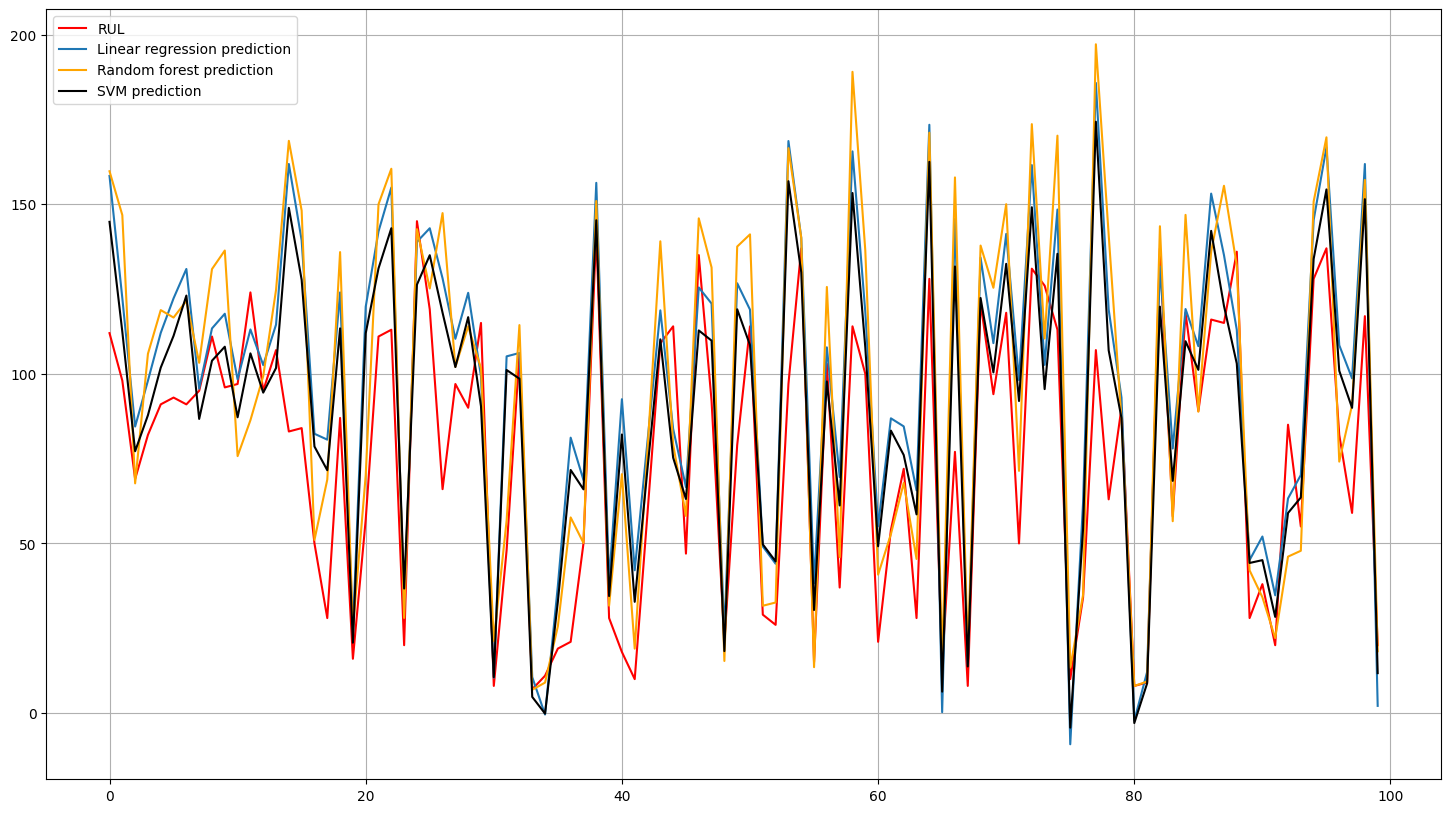

In [0]:
#TEST 1 linear regression
start_1=dt.now()
lm=LinearRegression()
lm.fit(X_train_s,Y_train)
Y_predict_train=lm.predict(X_train_s)
Y_predict_test = lm.predict(X_test_s)
print('Linear Regression evaluation score: ')
print('run time equals: '+str((dt.now() - start_1).seconds)+'s')
evaluate(Y_train, Y_predict_train, 'train')
evaluate(Y_test, Y_predict_test)
fig = plt.figure(figsize=(18,10))
plt.plot(Y_test,color='red', label='RUL')
plt.plot(Y_predict_test, label='Linear regression prediction')
plt.legend(loc='upper left')
plt.grid(True)

#Test 2 decision tree
start_2=dt.now()
rf = RandomForestRegressor(max_features="sqrt", random_state=42)
rf.fit(X_train_s,Y_train)
Y_predict_train_rf=rf.predict(X_train_s)
Y_predict_test_rf = rf.predict(X_test_s)
print('Random Forest Regressor evaluation: ')
print('run time equals: '+str((dt.now() - start_2).seconds)+'s')
evaluate(Y_train, Y_predict_train_rf, 'train')
evaluate(Y_test, Y_predict_test_rf)
plt.plot(Y_predict_test_rf,color='orange', label='Random forest prediction')
plt.legend(loc='upper left')
plt.grid(True)

#Test support vector machine (SVM)
start_3 = dt.now()
svm= SVR(kernel='linear')
svm.fit(X_train_s,Y_train)
svm_train_prediction=svm.predict(X_train_s)
svm_test_predict=svm.predict(X_test_s)
print('Support vector machine evaluation')
print('run time equals: '+str((dt.now() - start_3).seconds)+'s')
evaluate(Y_train,svm_train_prediction,'train')
evaluate(Y_test,svm_test_predict)
plt.plot(svm_test_predict,color='black',label='SVM prediction')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


The results of the three predictive models used show varied performances, highlighting their respective strengths and limitations. Linear regression, although fast with a runtime of 0 seconds, shows moderate performance. On the training set, it obtains an R² of 0.579 and an RMSE of 44.67, while on the test data, its R² drops to 0.408 with an RMSE of 31.95. This indicates that the model captures linear trends well, but it has difficulty capturing complex or nonlinear relationships in the data.
The Random Forest model, with a runtime of 4 seconds, shows strong performance on the training data, achieving an R² of 0.949 and an RMSE of 15.44. However, it suffers from a generalization decline on the test data, where its R² drops to 0.392 with an RMSE of 32.38. This difference suggests an overfitting problem, where the model overfits the training data, reducing its ability to predict well on new data.
Finally, the SVM (Support Vector Machine) model stands out as the best performer, although it is also the slowest with an execution time of 11 seconds. It presents a satisfactory balance between training and test data. On the training set, its R² reaches 0.561 with an RMSE of 45.64, while on the test data, it displays the best overall performance with an R² of 0.601 and an RMSE of 26.22. This model seems capable of capturing complex relationships while avoiding overfitting.